In [2]:
# imports
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

from mpl_toolkits.basemap import Basemap

import gzip
import pickle
import copy

import spacepy.irbempy as irbem

import spacepy.time as spt
import spacepy.coordinates as spc

import ctypes as ct
import datetime
import xflib

In [6]:
# # Let's do it totally realistically:
# q = -1.602e-19
# m = 9.1e-31
# B0 = 30e-6

R2D = 180.0/np.pi
D2R = np.pi/180.0
# R_E = 6371.
# import numpy as np
# from numpy import arctan2, sqrt
# # import numexpr as ne

def spherical_to_cartesian(r_in):
    x = r_in[0]*np.cos(D2R*r_in[1])*np.cos(D2R*r_in[2])
    y = r_in[0]*np.cos(D2R*r_in[1])*np.sin(D2R*r_in[2])
    z = r_in[0]*np.sin(D2R*r_in[1])
    #print x, y, z
    return np.array([x, y, z]).T

def cartesian_to_spherical(x_in):
    ''' cartesian to spherical (degrees)'''
    rads = np.linalg.norm(x_in,axis=0)
    lons = R2D*np.arctan2(x_in[1], x_in[0]);
    lats = R2D*np.arcsin(x_in[2]/rads)
    return np.array([rads, lats, lons]).T

def bfield(x_in):
    Bo = (3.12e-5)
    D2R = np.pi/180.
    R_E = 6371e3;

    R = x_in[0]
    theta = (90. - x_in[1])*D2R
    phi   = x_in[2]*D2R
    
    Bor3  = Bo*pow(R, -3.0)
    
    Brad = -2.0*Bor3*np.cos(theta);
    Btheta = -1.0*Bor3*np.sin(theta);
    Bphi = 0.0;    # Dipole model has no variation in longitude (here for completeness)

    B_out = np.zeros(3)
    B_out[0] = Brad;        # Up
    B_out[1] = Btheta;      # South
    B_out[2] = Bphi;        # East

    return B_out
def transform_data_sph2car(lat, lon, d_in):
    D2R = np.pi/180.

    M = np.zeros([3,3])
    d_out = np.zeros(3)

    theta = D2R*(90. - lat)
    phi   = D2R*lon

    st = np.sin(theta)
    sp = np.sin(phi)
    ct = np.cos(theta)
    cp = np.cos(phi)

    M[0,0] = st*cp;    M[0,1] = ct*cp;   M[0,2] = -sp;
    M[1,0] = st*sp;    M[1,1] = ct*sp;   M[1,2] = cp;
    M[2,0] = ct;       M[2,1] = -st;     M[2,2] = 0;

    d_out = np.dot(M, d_in)

    return d_out

def transform_data_car2sph(lat, lon, d_in):
    D2R = np.pi/180.

    M = np.zeros([3,3])
    d_out = np.zeros(3)

    theta = D2R*(90. - lat)
    phi   = D2R*lon

    st = np.sin(theta)
    sp = np.sin(phi)
    ct = np.cos(theta)
    cp = np.cos(phi)

    M[0,0] = st*cp;    M[0,1] = ct*cp;   M[0,2] = -sp;
    M[1,0] = st*sp;    M[1,1] = ct*sp;   M[1,2] = cp;
    M[2,0] = ct;       M[2,1] = -st;     M[2,2] = 0;

    d_out = np.dot(M.T, d_in)

    return d_out

In [4]:
# Load coastlines (for plotting)
with gzip.open('python_local/mag_coastlines.gzip','rb') as file:
    coast = pickle.load(file)
print coast.keys()

['lat', 'lon']


/shared/users/asousa/software/python2/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in less


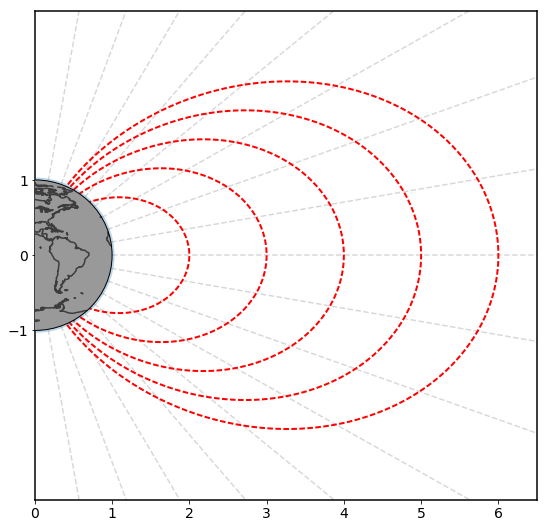

In [4]:


# --------------- Latex Plot Beautification --------------------------
fig_width = 8 
fig_height = 8
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


L = 6
Ls = [2,3,4,5,6]


fig, ax = plt.subplots(1,1)
[i.set_linewidth(1.5) for i in ax.spines.itervalues()]
# ax.plot(positions[:,0], positions[:,2], linewidth=2)
# ax.set_aspect('equal')
ax.set_xlim([0,L + 0.5])
ax.set_ylim(np.array([-1, 1])*(L + 0.5)/2.)
ax.set_yticks([ -1, 0, 1])
# Draw the earth
# Plot the earth
earth = plt.Circle((0,0),1,facecolor='0.6',alpha=1,edgecolor='k', zorder=100)
iono  = plt.Circle((0,0),1 + 200./6378.,alpha=0.3, zorder=99)
 
ax.add_patch(earth)                    # The earth (round)
ax.add_patch(iono)
coastpoints = np.vstack([coast['lon']/90. + 0.3, coast['lat']/90.])
coastr = np.linalg.norm(coastpoints, axis=0)
coastmask = (coastr < 1) | (np.isnan(coastr))
ax.plot(coastpoints[0,coastmask], coastpoints[1,coastmask],'k', zorder=101, alpha=0.6)



# ax2=fig.add_axes([0,0.25,0.52,0.5])
# m = Basemap(projection='ortho',lon_0=-105,lat_0=-25,resolution='l',ax=ax2)
# m.bluemarble(scale=.5) # scale=.1 for low resolution

# Plot latitude lines:

for la in np.arange(-80, 81, 10):
    rr = np.array([1,10])
    plt.plot(rr*np.cos(la*D2R), rr*np.sin(la*D2R),'--',color='grey', alpha=0.3)
    
for L in Ls:
    # Plot the fieldlines
    lam = np.linspace(-80,80,181)
    L_r = L*pow(np.cos(lam*D2R),2)
    Lx  = L_r*np.cos(lam*D2R)
    Ly  = L_r*np.sin(lam*D2R)
    ax.plot(Lx,Ly,color='r',linewidth=2,linestyle='dashed')  # Field line

In [5]:
import spacepy.irbempy as irbem

import spacepy.time as spt
import spacepy.coordinates as spc
# import spacepy.irbempy as ib
t = spt.Ticktock(datenum, 'ISO')
tmp = spc.Coords([1,45,0],'GEO', 'sph')
tmp.ticks = t
y = tmp.convert('GEO','car')
# y = spc.Coords([[3,0,0]], 'GEO', 'car')

# print tmp
# print y


print ib.get_Bfield(t, y, extMag = '0')

print pigrf.igrf12.igrf12syn(0, datenum.year, 1, tmp.radi, tmp.lati, tmp.long)

NameError: name 'datenum' is not defined

In [6]:
import ctypes as ct
import datetime
import xflib
class geopack(object):
    '''A python wrapper class around Tsyganenko`s Geopack library.
#        (You built the .so file using 3dWIPP/lib/geopack/ make shared)
#     '''
    def __init__(self):
        self.D2R = 3.141592653589793238462643/180.
        self.R2D = 180./3.141592653589793238462643

        # data types
        self.i2 = ct.c_int*2
        self.d3 = ct.c_double*3
        
        lib_path = '/shared/users/asousa/WIPP/Thesis figures/libgeopackd.so'
        ct.cdll.LoadLibrary(lib_path)
        self.g = ct.CDLL(lib_path)
        
        self.igrf_gsw = self.g.igrf_gsw_08_
        self.recalc = self.g.recalc_08_
        self.smgsw  = self.g.smgsw_08_
        
        self.xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')


    def init_igrf(self, date):
        year = ct.c_int(date.year)
        doy = ct.c_int(date.timetuple().tm_yday)
        hr = ct.c_int(date.hour)
        mn = ct.c_int(date.minute)
        sc = ct.c_int(date.second)
        vgsex = ct.c_double(-400.0)
        vgsey = ct.c_double(0)
        vgsez = ct.c_double(0)
        
        # Set current date for IGRF
        self.recalc(ct.byref(year), ct.byref(doy), ct.byref(hr), ct.byref(mn), ct.byref(sc),
                    ct.byref(vgsex), ct.byref(vgsey), ct.byref(vgsez))
        
    def igrf_sm(self, x_sm):
        # Convert sm coordinate to gsm:
        xs = ct.c_double(x_sm[0])
        ys = ct.c_double(x_sm[1])
        zs = ct.c_double(x_sm[2])
        xg = ct.c_double()
        yg = ct.c_double()
        zg = ct.c_double()
        direction = ct.c_int(1)
        
        self.smgsw(ct.byref(xs),ct.byref(xs),ct.byref(xs),
                   ct.byref(xg),ct.byref(yg),ct.byref(zg),
                   ct.byref(direction))

        # Call IGRF (in gsm coordinates):
        hxg = ct.c_double()
        hyg = ct.c_double()
        hzg = ct.c_double()
        self.igrf_gsw(ct.byref(xg),ct.byref(yg),ct.byref(zg),
                      ct.byref(hxg),ct.byref(hyg),ct.byref(hzg))

        # Rotate back to SM:
        direction = ct.c_int(0)
        hxs = ct.c_double()
        hys = ct.c_double()
        hzs = ct.c_double()
    
        self.smgsw(ct.byref(hxs),ct.byref(hys),ct.byref(hzs),
                   ct.byref(hxg),ct.byref(hyg),ct.byref(hzg),
                   ct.byref(direction))

        return [hxs.value, hys.value, hzs.value]
gp = geopack()

d = datetime.datetime(2010,6,1,18,0,0)
gp.init_igrf(d)

x_in = [0.707, 0, 0.707]
gp.igrf_sm(x_in)
# # gp.gp.igrf_gsw
# lib_path = '/shared/users/asousa/WIPP/Thesis figures/libgeopackd.so'
# ct.cdll.LoadLibrary(lib_path)
# gp = ct.CDLL(lib_path)
        
# igrf_gsw = gp.igrf_gsw_08_


# igrf_gsw



[-13258.980977600386, -16577.827290680645, 2515.7882104622086]

In [7]:
t = ct.c_int(5)
t.value

5

In [43]:
#!/usr/bin/env python
from matplotlib.pyplot import show
#
from gridaurora.worldgrid import latlonworldgrid
import pyigrf12 as pigrf
import xflib
import datetime
xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')



# x,y,z,f = igrf12syn(isv,date,itype,alt,colat,elong)
datenum = datetime.datetime(2010,6,1,21,40,0)
alt  = (6371. + 1000.0)/6371.
clat = 45
clon = 30

start_coord = xf.rllmag2sm([alt, clat, clon], datenum)
print start_coord

def trace_IGRF(date, start_coord, stop_alt):
    
    gp = geopack()  # Tsyganenko geo tools (igrf, etc)
    
    TRACER_MAX = 1000
    R_E = 6371.
    ds = 0.05
    points = []
    xcur = start_coord
    i = 0
    
    gp.init_igrf(date)

    while i < TRACER_MAX:
        points.append(xcur)
        
#         [alt, lat, lon] = xf.sm2rllmag(xcur, date)
#         print alt, lat, lon
#         [east, north, up, bmag] = pigrf.igrf12.igrf12syn(0, date.year, 1, alt, lat, lon)

        [x,y,z] = gp.igrf_sm(xcur)
        bmag = np.linalg.norm(np.array([x,y,z]))

#         x,y,z = xf.transform_data_sph2car()
        dx = x/bmag
        dy = y/bmag
        dz = z/bmag

        xtmp = xcur + ds*np.array([dx, dy, dz])
        xalt = np.linalg.norm(xtmp)
        xcur = xtmp
        print xalt
        if xalt < 1:
            print "hit stop condition"
            break
#         print dx, dy, dz
#     print xcur
#     print xtmp
#         print xalt
        i += 1
    return np.array(points)
    
fieldline = trace_IGRF(datenum, start_coord, 100.)
print fieldline

[-0.2595016387222358, 0.7758469849322709, 0.8180951317102559]
1.15292417629
1.15889237066
1.16658150251
1.17457476806
1.18244800042
1.18986663189
1.19638722584
1.20146374273
1.20454721215
1.20521634944
1.20327071135
1.19874351217
1.19184836344
1.18290547834
1.17228074225
1.16034704693
1.14746400021
1.13396931967
1.12017659891
1.10637608395
1.09283655268
1.07980729676
1.06751972768
1.05618841842
1.04601155048
1.03717082321
1.02983093127
1.02413874489
1.02022234337
1.01819005748
1.01812967139
1.02010791792
1.02417037222
1.03034181158
1.03862706493
1.04901233073
1.06146690261
1.07594521081
1.09238906992
1.11073001794
1.1308916384
1.15279177338
1.17634455576
1.20146221257
1.22805661314
1.25604055478
1.28532879387
1.31583884095
1.3474915449
1.38021149482
1.41392726882
1.44857155762
1.48408118885
1.5203970744
1.55746410051
1.59523097665
1.63365005654
1.67267714185
1.71227127679
1.75239454012
1.7930118391
1.83409070895
1.87560112014
1.9175152951
1.95980753527
2.00245405903
2.04543285052
2.088

In [54]:
def trace_fieldline(incoord, bmodel, max_steps=5000, max_angle = 0.5):
    # Bmodel index number (from irbempy)
    #             - 0 = IGRF
    #             - 1 = Eccentric tilted dipole
    #             - 2 = Jensen&Cain 1960
    #             - 3 = GSFC 12/66 updated to 1970
    #             - 4 = User-defined model (Default: Centred dipole + uniform [Dungey open model] )
    #             - 5 = Centred dipole
    max_stepsize=0.1
    stepsize = max_stepsize  # Initially...
 
    cur_pos = incoord.convert('MAG','sph')
    start_alt = cur_pos.radi
    cur_pos = incoord.convert('MAG','car')
    in_time = cur_pos.ticks[0]
    
    prev_pos = spc.Coords(cur_pos.data, 'MAG','car')
    print prev_pos
    # Step one step to find out propagation direction:
    B = irbem.get_Bfield(cur_pos.ticks, cur_pos, extMag='0',options=[1,0,0,0,bmodel], omnivals=None) 
    bdir = B['Bvec']/(1.0*np.linalg.norm(B['Bvec']))
    tmp_data = copy.copy(cur_pos.data)
    tmp_data += stepsize*bdir
    
    stepsign = 1 - 2.0*(np.linalg.norm(tmp_data) < np.linalg.norm(cur_pos.data))
#     print "stepsign is: ", stepsign

    ov = []
    opts = [0,0,0,0,int(bmodel)]
    count = 0
#     for x in range(max_steps):
    while(1):
        B = irbem.get_Bfield(cur_pos.ticks, cur_pos, extMag='0',options=[1,0,0,0,bmodel], omnivals=None)
        
        bdir = B['Bvec']/np.linalg.norm(B['Bvec'])
        
        # Get error at this next step size:
        p1 = np.array([cur_pos.x[0], cur_pos.y[0], cur_pos.z[0]])
        p2 = p1 + stepsign*stepsize*bdir.ravel()
        step_angle = R2D*np.arccos(np.dot(p1, p2)/np.linalg.norm(p1)/np.linalg.norm(p2))

        # Refine step size if we're over our threshold
        if step_angle > max_angle:
            stepsize*=0.5
            print "down"
        else:
#             print count, stepsize
            cur_pos.x += stepsign*stepsize*bdir[:,0]
            cur_pos.y += stepsign*stepsize*bdir[:,1]
            cur_pos.z += stepsign*stepsize*bdir[:,2]

            ov.append([cur_pos.x[0], cur_pos.y[0], cur_pos.z[0]])
            count += 1
            
            # bump up for speed if we're doing fine
            if (step_angle < max_angle/2.0) and (stepsize < max_stepsize):
                stepsize*=2.0
                print "up"
        if (len(ov) > 0) and (np.linalg.norm(ov[-1]) < start_alt):
#             print "reached Earth"
            break
        if (count > max_steps):
            print "Exceeded max steps"
            break
    
    ov = np.array(ov)
    
    outs = spc.Coords(ov,'MAG','car')
    
    return outs



lat = 54; lon = 0
incoord = spc.Coords([[(R_E + H_M)/R_E, lat, lon]],'MAG','sph',units=['Re','deg','deg'])
t = datetime.datetime(2010,1,1,0,0,0)
incoord.ticks=spt.Ticktock(t)
incoord = incoord.convert('MAG','car')
fl = trace_fieldline(incoord, 0, max_angle=0.1, max_steps=10000)


Coords( [[0.5877852522924731, 0.0, 0.8090169943749475]] , 'MAG', 'car')
down
down
down
down
down
down
up
up
up
up
up
up
Exceeded max steps


[ 45.          54.73561032  60.          63.43494882  65.90515745]


/shared/users/asousa/software/python2/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in less


NameError: name 'fl' is not defined

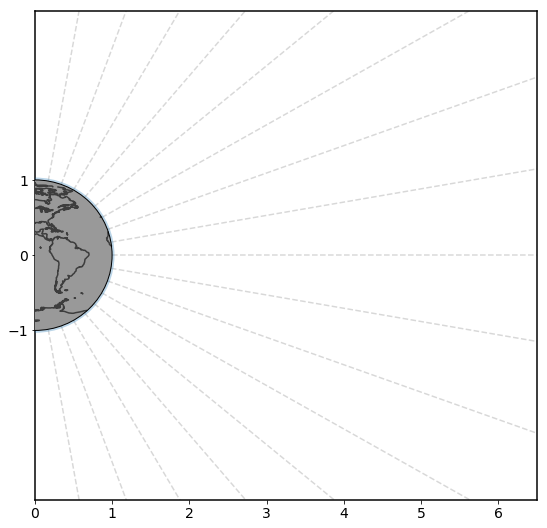

In [5]:


# --------------- Latex Plot Beautification --------------------------
fig_width = 8 
fig_height = 8
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


L = 6
Ls = [2,3,4,5,6]
lam_s = np.arccos(np.sqrt(1./np.array(Ls)))*R2D
print lam_s
fig, ax = plt.subplots(1,1)
[i.set_linewidth(1.5) for i in ax.spines.itervalues()]
# ax.plot(positions[:,0], positions[:,2], linewidth=2)
# ax.set_aspect('equal')
ax.set_xlim([0,L + 0.5])
ax.set_ylim(np.array([-1, 1])*(L + 0.5)/2.)
ax.set_yticks([ -1, 0, 1])
# Draw the earth
# Plot the earth
earth = plt.Circle((0,0),1,facecolor='0.6',alpha=1,edgecolor='k', zorder=100)
iono  = plt.Circle((0,0),1 + 200./6378.,alpha=0.3, zorder=99)
 
ax.add_patch(earth)                    # The earth (round)
ax.add_patch(iono)
coastpoints = np.vstack([coast['lon']/90. + 0.3, coast['lat']/90.])
coastr = np.linalg.norm(coastpoints, axis=0)
coastmask = (coastr < 1) | (np.isnan(coastr))
ax.plot(coastpoints[0,coastmask], coastpoints[1,coastmask],'k', zorder=101, alpha=0.6)



# ax2=fig.add_axes([0,0.25,0.52,0.5])
# m = Basemap(projection='ortho',lon_0=-105,lat_0=-25,resolution='l',ax=ax2)
# m.bluemarble(scale=.5) # scale=.1 for low resolution

# Plot latitude lines:

for la in np.arange(-80, 81, 10):
    rr = np.array([1,10])
    plt.plot(rr*np.cos(la*D2R), rr*np.sin(la*D2R),'--',color='grey', alpha=0.3)


# ax.plot(np.sqrt(fl.x**2 + fl.y**2), fl.z)
ax.plot(fl.x, fl.z)


for L in Ls:
    # Plot the fieldlines
    lam = np.linspace(-80,80,181)
    L_r = L*pow(np.cos(lam*D2R),2)
    Lx  = L_r*np.cos(lam*D2R)
    Ly  = L_r*np.sin(lam*D2R)
    ax.plot(Lx,Ly,color='r',linewidth=2,linestyle='dashed')  # Field line

(400,) (400,)
(16, 2)
total length 160000
doing 0 100000
doing 100000 160000
(160000, 3)
(400, 400)


/shared/users/asousa/software/python2/lib/python2.7/site-packages/ipykernel/__main__.py:84: RuntimeWarning: invalid value encountered in less


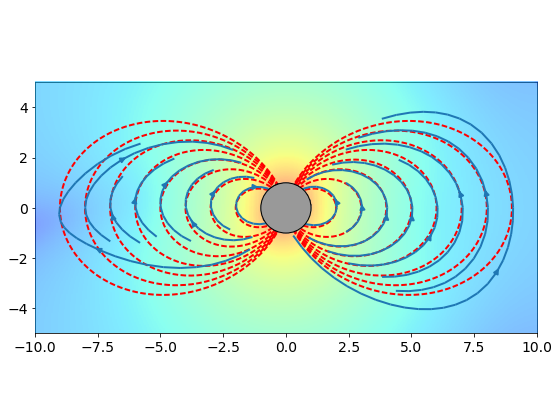

In [10]:
## Try it with streamplot, because nothing else fuckin' works


# glats = np.linspace(-80, 80, 161)
# grs   = np.linspace(1, 10, 21)

# gla, gr = np.meshgrid(glats, grs)

# gla = gla.ravel()
# gr  = gr.ravel()
# print np.shape(gla)
# gc = np.array([gr*np.cos(D2R*gla), gr*np.sin(D2R*gla)])

gxx = np.linspace(-10, 10, 400)
gyy = np.linspace(-8,8, 400)
bmodel = 0


print np.shape(gxx), np.shape(gyy)
gx, gz = np.meshgrid(gxx, gyy)
gx = gx.ravel()
gz = gz.ravel()
gc = np.array([gx, gz])


L = 6
Ls = np.arange(2,10)
lam_s = np.arccos(np.sqrt(1./np.array(Ls)))*R2D

Ls = np.concatenate([-Ls, Ls])
# startpoints = np.array([np.cos(lam_s*D2R), np.sin(lam_s*D2R)]).T
startpoints = np.array([Ls, np.zeros_like(Ls)]).T
print np.shape(startpoints)

fig, ax = plt.subplots(1,1)

do_field = True
if do_field:
    # Get some field values:
    field = []
    Bv = None
    Bmag = None
    # cv = np.vstack([gx,np.zeros_like(gx),gz]).T
    # pos = spc.Coords(cv,'MAG','car')
    # t = datetime.datetime(2010,6,1,0,0,0)
    # tv = spt.Ticktock([t for x in gx.ravel()])

    chunk_size = 100000
    start_ind = 0
    stop_ind = min(len(gx.ravel()),chunk_size)

    print "total length", len(gx.ravel())
    while (start_ind < len(gx.ravel())):
        print "doing", start_ind, stop_ind
        cv = np.vstack([gx[start_ind:stop_ind],np.zeros(stop_ind-start_ind),gz[start_ind:stop_ind]]).T
        pos = spc.Coords(cv,'GEO','car')
        t = datetime.datetime(2010,6,1,12,0,0)
        tv = spt.Ticktock([t for x in range(stop_ind-start_ind)])
        B = irbem.get_Bfield(tv, pos, extMag='T05',options=[1,0,4,4,bmodel], omnivals=None)        

        if Bv is None:
            Bv = B['Bvec']
            Bmag = B['Blocal']
        else:
            Bv = np.concatenate([Bv, B['Bvec']])
            Bmag = np.concatenate([Bmag, B['Blocal']])

        start_ind = stop_ind
        stop_ind = min(len(gx.ravel()), start_ind + chunk_size)

    # B = irbem.get_Bfield(tv, pos, extMag='0',options=[1,0,0,0,bmodel], omnivals=None)
    # Bv = B['Bvec']
    print np.shape(Bv)



earth = plt.Circle((0,0),1,facecolor='0.6',alpha=1,edgecolor='k', zorder=106)
iono  = plt.Circle((0,0),1 + 200./6378.,alpha=0.3, zorder=105)
 
ax.add_patch(earth)                    # The earth (round)
ax.add_patch(iono)
coastpoints = np.vstack([coast['lon']/90. + 0.3, coast['lat']/90.])
coastr = np.linalg.norm(coastpoints, axis=0)
coastmask = (coastr < 1) | (np.isnan(coastr))
ax.plot(coastpoints[0,coastmask], coastpoints[1,coastmask],'k', zorder=101, alpha=0.6)

ax.pcolorfast(gxx,gyy,np.log10(Bmag.reshape([len(gyy), len(gxx)])), vmin = 0, vmax = 6, cmap= plt.cm.jet, zorder=90, alpha=0.5)





u = Bv[:,0].reshape([len(gyy),len(gxx)])
v = Bv[:,2].reshape([len(gyy),len(gxx)])
print np.shape(u)
ax.streamplot(gxx, gyy, u, v, linewidth=2, start_points = startpoints, zorder=102)


for L in Ls:
    # Plot the fieldlines
    lam = np.linspace(-80,80,181)
    L_r = L*pow(np.cos(lam*D2R),2)
    Lx  = L_r*np.cos(lam*D2R)
    Ly  = L_r*np.sin(lam*D2R)
    ax.plot(Lx,Ly,color='r',linewidth=2,linestyle='dashed', zorder=100)  # Field line

ax.set_xlim([-10, 10])
ax.set_ylim([-5, 5])
ax.set_aspect('equal')




## HEY!! A thought -- this really can be used to show how valid it would be to remap fieldline footprints between
## igrf and dipole -- in the plasmapshere, it looks to be pretty dipolar; igrf just changes the footprint.

20.6257420353 47080849.2163


ValueError: Axes don't match array shape. Got (200, 400), expected (399, 199).

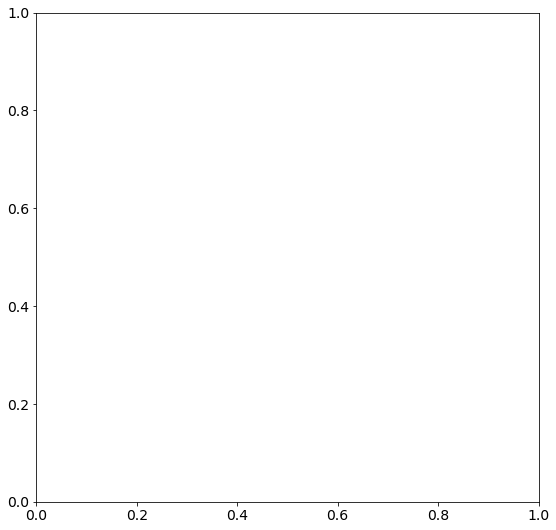

In [239]:
fig, ax = plt.subplots(1,1)

Bmag = np.linalg.norm(Bv, axis=1)
print np.min(Bmag), np.max(Bmag)
ax.pcolorfast(gxx,gyy,np.log10(Bmag.reshape([len(gxx), len(gyy)])), vmin = 0, vmax = 6, cmap= plt.cm.jet)
ax.set_aspect('equal')

## This one for the thesis:

In [8]:
saved_lines = dict()

/shared/users/asousa/software/python2/lib/python2.7/site-packages/ipykernel/__main__.py:81: RuntimeWarning: invalid value encountered in less


hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!
hit the earth!


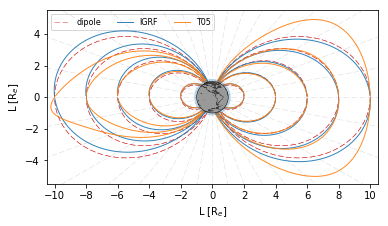

In [9]:
from scipy.integrate import ode


def B_dir(t, x, bmodel, extfield, direction):

    
    pos = spc.Coords([x[0],0,x[1]],'GEO','car')
    tt = datetime.datetime(2010,6,1,12,0,0)
    tv = spt.Ticktock(tt)
    B = irbem.get_Bfield(tv, pos, extMag=extfield,options=[1,0,0,0,bmodel], omnivals=None) 
    
    Bmags = direction*B['Bvec']/B['Blocal']
    
    return [Bmags[0][0], Bmags[0][2]]

def trace_fieldline_ODE(p0, bmodel, extfield, direction):
    # Bmodel index number (from irbempy)
    #             - 0 = IGRF
    #             - 1 = Eccentric tilted dipole
    #             - 2 = Jensen&Cain 1960
    #             - 3 = GSFC 12/66 updated to 1970
    #             - 4 = User-defined model (Default: Centred dipole + uniform [Dungey open model] )
    #             - 5 = Centred dipole

    x = []
    z = []
    dt = 0.1
    r = ode(B_dir)
    r.set_integrator('vode')
    
    r.set_initial_value(p0,0)
    r.set_f_params(bmodel, extfield, direction)
    counts = 0
    while r.successful():
        r.integrate(r.t + dt)
        x.append(r.y[0])
        z.append(r.y[1])
        
#         print r.y, counts
        counts+=1
        if np.linalg.norm(r.y) < 1:
            print "hit the earth!"
            break
            
        if counts > 500:
            print "max count!"
            break
    return x, z





# --------------- Latex Plot Beautification --------------------------
fig_width = 4.5#4 
fig_height = 2.25
fig_size =  [fig_width+1,fig_height+1]
params = {'font.family': 'Sans Serif',
          'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 8,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

fig, ax = plt.subplots(1,1)


# Plot the Earth
earth = plt.Circle((0,0),1,facecolor='0.6',alpha=1,edgecolor='k', linewidth=0.5, zorder=100)
iono  = plt.Circle((0,0),1 + 1000./6378.,alpha=0.3, zorder=99)
 
ax.add_patch(earth)                    # The earth (round)
ax.add_patch(iono)
coastpoints = np.vstack([coast['lon']/90. + 0.3, coast['lat']/90.])
coastr = np.linalg.norm(coastpoints, axis=0)
coastmask = (coastr < 1) | (np.isnan(coastr))
ax.plot(coastpoints[0,coastmask], coastpoints[1,coastmask],'k-', zorder=101, linewidth=0.5, alpha=0.6)

for la in np.arange(-90, 90, 10):
    rr = np.array([-20,20])
    plt.plot(rr*np.cos(la*D2R), rr*np.sin(la*D2R),'--',color='grey', linewidth=0.5, alpha=0.3, zorder=10)




    
igrfplots = []
tsygplots = []
dipoleplots=[]
# Trace some fieldlines:
for L in [-10,-8,-6,-4,-2, 2,4,6,8,10]:
# for L in [-10,10]:
    
#     deg = -1.0*np.arccos(np.sqrt(1./L))
#     startpoint = np.array([np.cos(deg), np.sin(deg)])
#     print startpoint

    for direction in [1, -1]: # Trace in both directions from start point

        startpoint = [L, 0] # Start from the equator
#         ax.plot(startpoint[0], startpoint[1],marker='o')
        
        # IGRF, no external field
        if not ('IGRF',L, direction) in saved_lines:
            x,z = trace_fieldline_ODE(startpoint,0,'0',direction)
            saved_lines[('IGRF',L, direction)] = [x,z]
        else:
            x,z = saved_lines[('IGRF',L, direction)]
            
        pigrf = ax.plot(x,z,color=plt.cm.Vega10(0), linewidth=1, alpha=0.9, zorder=97, label='IGRF')
        igrfplots.append(pigrf)
        
        #IGRF, Tsyg 05 external field
        if not ('Tsyg', L, direction) in saved_lines:
            x,z = trace_fieldline_ODE(startpoint,0,'T05',direction)
            saved_lines[('Tsyg',L,direction)] = [x,z]
        else:
            x,z = saved_lines[('Tsyg',L, direction)]
        ptsyg = ax.plot(x,z,color=plt.cm.Vega10(1), linewidth=1, alpha=0.9, zorder=98, label='T05')
        tsygplots.append(ptsyg)
        
        # Dipole field
        lam = np.linspace(-80,80,181)
        L_r = L*pow(np.cos(lam*D2R),2)
        Lx  = L_r*np.cos(lam*D2R)
        Ly  = L_r*np.sin(lam*D2R)
        pdip = ax.plot(Lx,Ly,linewidth=0.5, color=plt.cm.Vega10(3), linestyle='dashed',alpha=0.9, zorder=96, label='dipole')  # Field line
        dipoleplots.append(pdip)

ax.set_xticks(np.arange(-10, 11, 2))
ax.set_xlim([-10.5,10.5])
ax.set_ylim([-5.5, 5.5])

ax.legend(handles=[pdip[0], pigrf[0], ptsyg[0]],  ncol=3, framealpha=None)






ax.set_aspect('equal')

ax.set_xlabel('L [R$_e$]')
ax.set_ylabel('L [R$_e$]')

fig.tight_layout()
fig.savefig('fieldline_models.pdf')
fig.savefig('fieldline_models.png',dpi=300)


## Plot field line footprints on a map:

In [255]:
from scipy.interpolate import interp1d

def B_dir_3D(t, x, bmodel, extfield, direction):

    
    pos = spc.Coords([x[0],x[1], x[2]],'GEO','car')
    tt = datetime.datetime(2010,6,1,12,0,0)
    tv = spt.Ticktock(tt)
    B = irbem.get_Bfield(tv, pos, extMag=extfield,options=[1,0,0,0,bmodel], omnivals=None) 
    
    Bmags = direction*B['Bvec']/B['Blocal']
    
    return [Bmags[0][0], Bmags[0][1], Bmags[0][2]]

def trace_fieldline_ODE_3D(p0, bmodel, extfield, direction):
    # Bmodel index number (from irbempy)
    #             - 0 = IGRF
    #             - 1 = Eccentric tilted dipole
    #             - 2 = Jensen&Cain 1960
    #             - 3 = GSFC 12/66 updated to 1970
    #             - 4 = User-defined model (Default: Centred dipole + uniform [Dungey open model] )
    #             - 5 = Centred dipole

    x = []
    y = []
    z = []
    dt = 0.1
    r = ode(B_dir_3D)
    r.set_integrator('vode')
    
    r.set_initial_value(p0,0)
    r.set_f_params(bmodel, extfield, direction)
    counts = 0
    while r.successful():
        r.integrate(r.t + dt)
        x.append(r.y[0])
        y.append(r.y[1])
        z.append(r.y[2])
        
#         print r.y, counts
        counts+=1
        if np.linalg.norm(r.y) < 1:
#             print "hit the earth!"
            break
            
        if counts > 500:
            print "max count!"
            break
            
    return np.array(x), np.array(y), np.array(z)








# fieldlines = [1.5, 2, 3, 4, 5]
fieldlines = [2, 4, 6, 8, 10]
lons = np.arange(0, 361, 5)
modes = ['dipole','IGRF']

# footprints = dict()

# startpoint = [L, 0, 0] # Start from the equator
# x,y,z = trace_fieldline_ODE_3D(startpoint, 1, '0', direction)
# print x[-1], y[-1], z[-1]

# pos = spc.Coords([x[-1],y[-1], z[-1]],'GEO','car')
# tt = datetime.datetime(2010,6,1,12,0,0)
# tv = spt.Ticktock(tt)
# pos.ticks=tv
# print pos.convert('GEO','sph')

for mode in modes:
    for L in fieldlines:
        for direction in [-1, 1]:



            key = (mode, L, direction)
            print key
            if not key in footprints:
                footprints[key] = []
                for lon in lons:
                    print lon
                    pos = spc.Coords([L, 0, lon],'GEO','sph')
                    tt = datetime.datetime(2010,6,1,12,0,0)
                    pos.ticks=spt.Ticktock(tt)
                    pos2 = pos.convert('GEO','car')
                    startpoint = [pos2.x[0], pos2.y[0], pos2.z[0]]

    #                 Trace fieldline:
                    if 'IGRF' in mode:
                        x,y,z = trace_fieldline_ODE_3D(startpoint, 0, '0', direction)
                    elif 'dipole' in mode:
                        x,y,z = trace_fieldline_ODE_3D(startpoint, 1, '0', direction)
                    elif 'T05' in mode:
                        x,y,z = trace_fieldline_ODE_3D(startpoint, 0, 'T05', direction)

                    pos = spc.Coords(zip(x,y,z),'GEO','car')
                    tt = datetime.datetime(2010,6,1,12,0,0)
                    tv = spt.Ticktock([tt for xx in x])
                    pos.ticks=tv
                    p2 = pos.convert('GEO','sph')

                    # Interpolate along radius to get the footprint at the earth:
                    intlat = interp1d(p2.data[:,0],p2.data[:,1])
                    intlon = interp1d(p2.data[:,0],p2.data[:,2])

                    footprints[key].append([intlat(1.0), intlon(1.0)])

    #                 footprints[key] = [p2.data[0][1], p2.data[0][2]]


('dipole', 2, -1)
('dipole', 2, 1)
('dipole', 4, -1)
('dipole', 4, 1)
('dipole', 6, -1)
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
('dipole', 6, 1)
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
('dipole', 8, -1)
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
('dipole', 8, 1)
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
8

In [260]:
# clean up an outlier:
# (this block looks for spikes in the gradient of the contour,
# then interpolates a new value using the points on either side)

# key = ('IGRF',5, -1)
key = ('dipole',6, 1)


val = footprints[key]
vals = np.array(val)
vals = vals[np.argsort(vals[:,1]),:]
# print vals

outlier_inds = np.where(np.abs(np.diff(vals[:,0])) > 3)
print vals[outlier_inds,:]
oli = outlier_inds[0][-1]
print oli
intp = interp1d([vals[oli-1,1], vals[oli+1, 1]], [vals[oli-1,0], vals[oli+1,0]])
vals[oli,0] = intp(vals[oli,1])

footprints[key] = vals

[[[  64.29879228 -153.08130176]
  [  67.57789674 -150.86863535]]]
6


In [254]:
with open('footprints.pkl','wb') as file:
    pickle.dump(footprints, file)

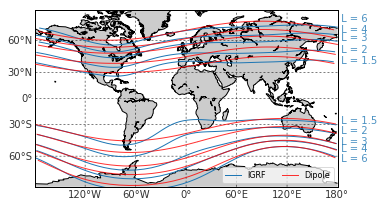

In [265]:
# print footprints.keys()
# --------------- Latex Plot Beautification --------------------------
fig_width = 4.5#4 
fig_height = 2.25
fig_size =  [fig_width+1,fig_height+1]
params = {'font.family': 'Sans Serif',
          'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 8,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------
fig, ax = plt.subplots(1,1)

# are the lat/lon values of the lower left and upper right corners
# of the map.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-179,urcrnrlon=180,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='0.8',lake_color='white')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.), labels = [1,0,0,0], alpha=0.8, linewidth=0.5)
m.drawmeridians(np.arange(-180.,181.,60.), labels = [0,0,0,1], alpha=0.8, linewidth=0.5)
m.drawmapboundary(fill_color='white')






for key, val in footprints.items():
    vals = np.array(val)
    vals = vals[np.argsort(vals[:,1]),:]
    x, y = m(vals[:,1], vals[:,0])

    a, b = m(180,2) # right side labels
    c, d = m(-180,2)# left side labels

    if key[1] in [1.5, 2, 3, 4, 6]:
        if key[0] in 'dipole':
            c = 'r' #plt.cm.Vega10(1)
            pdip = m.plot(x, y, linewidth=1, color=c, label='Dipole', alpha=0.8, zorder=99)

        if key[0] in 'IGRF':
            c = plt.cm.Vega10(0)
            pigrf = m.plot(x, y, linewidth=1,color=c, label='IGRF')
#             ax.text(a, (y[-1] - key[2]*1e6 + (5e5)*key[1]*key[2]),' L = %g'%key[1], color = c, alpha=0.8, zorder=100)    
            ax.text(a, (y[-1] -key[2]*5e5 + key[1]*key[2]*2e5),' L = %g'%key[1], color = c, alpha=0.8, zorder=100)    


#     if key[0] in 'T05':
#         c = 'k' #plt.cm.Vega10(1)
#         ptsyg = m.plot(x, y, linewidth=1, color=c, linestyle='--', label='T05', zorder=98)
# #         ax.text(-4e6, y[0],' L = %g'%key[1], color = plt.cm.Vega10(1))        


ax.legend(handles=[pigrf[0], pdip[0]], framealpha=0.7, ncol=3)

fig.savefig('Lshell_contours.pdf')

#     if key[0] in 'T05':
#         m.plot(val[1], val[0],'rx')

#     print x[-1], y[-1]
plt.show()

In [123]:
# Sort 'em out:

np.shape(np.array(footprints[('IGRF',2,1)]))

tmp = np.array(val)

print vals[:,0]
np.argsort(vals[:,0])

[ -38.80208921  -37.96529442  -37.58963931  -37.21826393  -36.59751554
  -35.76970406  -34.88273857  -34.11230337  -33.56334397  -33.28266043
  -33.25649109  -33.41977914  -33.69489754  -34.04889791  -34.51254635
  -35.14471166  -35.98936596  -37.05940648  -38.33355813  -39.80768775
 -172.25686558 -163.49784938 -154.62450622 -145.64553273 -136.44330435
 -126.84950562 -116.51137215 -104.76320203  -90.6548493   -73.76275544
  -59.21885671  -55.70723154  -51.11321315  -46.67722906  -43.06392529
  -40.44791091]


array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 19,
        0, 18,  1,  2,  3, 17,  4, 16,  5, 15,  6, 14,  7, 13, 12,  8, 11,
        9, 10])